# Assignment 2
This file covers the solutions to the 3 questions on assignment 2.
1. Implement C4.5 decision tree classifier.
2. Evaluate the impact of noise on C4.5 decision tree classifier.
3. Design a feature selection algorithm and apply to MNIST dataset.

In [255]:
# import packages
import pandas
import numpy as np
import scipy as sp
import scipy.linalg as sl
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from mlxtend.data import loadlocal_mnist

## Question 1

In [256]:
# load glass and tic tac toe datasets
glass_dataframe = pandas.read_csv('datasets/glass.data', header=None, engine='python')
tictactoe_dataframe = pandas.read_csv('datasets/tic-tac-toe.data', header=None, engine='python')

# label encoding for tictactoe targets
le = LabelEncoder()
tictactoe_dataframe[9] = le.fit_transform(tictactoe_dataframe[9])

# seperate featres from targets
glass_X = glass_dataframe.iloc[:,1:-1].values
glass_Y = glass_dataframe.iloc[:,-1].values
tictactoe_X = tictactoe_dataframe.iloc[:,:-1].values
tictactoe_Y = tictactoe_dataframe.iloc[:,-1].values

# feature names for each datset
glass_feature_names = np.array(['RI', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Ba', 'Fe'])

tictactoe_feature_names = np.array(['top-left', 'top-middle', 'top-right',
                          'middle-left', 'middle-middle', 'middle-right',
                          'bottom-left', 'bottom-middle', 'bottom-right'])

In [278]:
glass_dataframe.nunique()

0     214
1     178
2     142
3      94
4     118
5     133
6      65
7     143
8      34
9      32
10      6
dtype: int64

In [279]:
glass_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 11 columns):
0     214 non-null int64
1     214 non-null float64
2     214 non-null float64
3     214 non-null float64
4     214 non-null float64
5     214 non-null float64
6     214 non-null float64
7     214 non-null float64
8     214 non-null float64
9     214 non-null float64
10    214 non-null int64
dtypes: float64(9), int64(2)
memory usage: 18.5 KB


In [280]:
tictactoe_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 958 entries, 0 to 957
Data columns (total 10 columns):
0    958 non-null object
1    958 non-null object
2    958 non-null object
3    958 non-null object
4    958 non-null object
5    958 non-null object
6    958 non-null object
7    958 non-null object
8    958 non-null object
9    958 non-null int32
dtypes: int32(1), object(9)
memory usage: 71.2+ KB


In [270]:
# implement C4.5 Decision Tree
def buildTree(x, y, features):
    numfeatures = len(features)
    numsamples = x.shape[0]
    
    # base case 1: check if attribute list empty
    if len(features) == 0:
        isLeafNode= True
        majorityClass = np.bincount(y).argmax()
        return dtNode(None, isLeafNode, majorityClass, None, None)
    
    # base case 2: check if all samples are of the same class
    elif len(set(y)) == 1:
        isLeafNode= True
        classLabel = y[0]
        return dtNode(None, isLeafNode, classLabel, None, None)
    
    # select next best feature and make recursive call to branch out
    else:
        isLeafNode = False
        majorityClass = np.bincount(y).argmax()
        feature_idx, feature_splits, threshold, isFeatureDiscrete = selectBestAttribute(x, y, features)
        
        # determine remaining features and remove best feature selected
        new_features = np.delete(features, feature_idx)
        new_x = np.delete(x, feature_idx, axis=1)
        
        # iterate over feature splits and create child nodes
        node = dtNode(threshold, isLeafNode, majorityClass, features[feature_idx], isFeatureDiscrete)
        for split in feature_splits:
            node.childNodes.append(buildTree(new_x[split], y[split], new_features))
        return node
        

# select best attribute based on gain ratio
def selectBestAttribute(x, y, features):
    best_feature_idx = None
    best_feature_splits = None
    best_feature_threshold = None
    best_feature_discrete = None
    best_gain = -np.inf
    
    for feature in features:
        feature_idx = np.argwhere(features == feature).ravel()
        data = x[:,feature_idx].ravel()
        
        # dealing with discrete features
        isFeatureDiscrete = isDiscrete(data)
        if isFeatureDiscrete:
            feature_values = np.unique(data)
            idx_subsets = []
            for feature_val in feature_values:
                idx_subset = np.argwhere(data == feature_val).ravel()
                idx_subsets.append(idx_subset)
            y_subsets = [y[idx] for idx in idx_subsets]
            
            gain = informationGain(y, y_subsets)
            if gain > best_gain:
                best_gain = gain
                best_feature_idx = feature_idx
                best_feature_splits = idx_subsets
                best_feature_threshold = feature_values
                best_feature_discrete = True
        
        # dealing with continuous features
        else:
            sortedData = np.sort(data)
            
            # iterate over all possible thresholds
            for i in range(len(sortedData)-1):
                if sortedData[i] != sortedData[i+1]:
                    pickThreshold = (sortedData[i] + sortedData[i+1]) / 2
                    leftIdx = np.argwhere(data <= pickThreshold).ravel()
                    rightIdx = np.argwhere(data > pickThreshold).ravel()
                    
                    idx_subsets = [leftIdx, rightIdx]
                    y_subsets = [y[idx] for idx in idx_subsets]
                                      
                    gain = gainRatio(y, y_subsets)
                    if gain > best_gain:
                        best_gain = gain
                        best_feature_idx = feature_idx
                        best_feature_splits = idx_subsets
                        best_feature_threshold = pickThreshold
                        best_feature_discrete = False
    
    return (best_feature_idx, best_feature_splits, best_feature_threshold, best_feature_discrete)

# check if feature is discrete or continuous using threshold of 10
def isDiscrete(data):
    if len(np.unique(data)) <= 3:
        return True
    else:
        return False
    
# gain ratio
def gainRatio(y, y_subsets):
    return informationGain(y, y_subsets) / splitInformation(y, y_subsets)

# information gain criteria
def informationGain(y, y_subsets):
    numsamples = len(y)
    numsubsets = len(y_subsets)
    
    # calculate initialEntropy
    initialEntropy = entropy(y)
    
    # calculate afterEntropy
    afterEntropy = 0
    for i in range(numsubsets):
        subset_weight = len(y_subsets[i]) / numsamples
        afterEntropy += subset_weight * entropy(y_subsets[i])
    
    return initialEntropy - afterEntropy

# split information criteria
def splitInformation(y, y_subsets):
    numsamples = len(y)
    numsubsets = len(y_subsets)
    
    SI = []
    for i in range(numsubsets):
        subset_ratio = len(y_subsets[i]) / numsamples
        SI_v = subset_ratio * np.log2(subset_ratio)
        SI.append(SI_v)
        
    return -np.sum(SI)

# entropy calculation
def entropy(y):
    counts = np.bincount(y)
    probabilities = counts[np.nonzero(counts)] / float(len(y))
    return sp.stats.entropy(probabilities, base=2)

# convert decision tree to list of rules
def convertTreeToListOfRules(dt):
    
    # base case
    if dt.isLeafNode:
        rule = Rule(dt.label)
        return rule
    
    # add rules from each node
    else:
        res = []
            
        # handling decision node that is discrete
        if dt.isFeatureDiscrete:
            for child, discrete_value in zip(dt.childNodes, dt.threshold):
                rules = convertTreeToListOfRules(child)
                rules = rules if type(rules) == list else [rules]
                
                for r in rules:
                    condition = [dt.label, 'e', discrete_value]
                    r.prependCondition(condition)
                    
                res += rules

        # handling decision node that is continuous
        else:
            ops = ['le', 'g']
            continuous_value = dt.threshold
            
            for child, op in zip(dt.childNodes, ops):
                rules = convertTreeToListOfRules(child)
                rules = rules if type(rules) == list else [rules]

                for r in rules:
                    condition = [dt.label, op, continuous_value]
                    r.prependCondition(condition)
                    
                res += rules
                
        return res


In [271]:
# predict the class_label of sample given the C4.5 tree
def predictClass(dt, x, feature_names):
    currNode = dt
    leafNode = dt.isLeafNode
    while not leafNode:
        idx = np.argwhere(feature_names == currNode.feature).ravel()
        
        # handling decision node that is discrete
        if currNode.isFeatureDiscrete:
            split_idx = np.argwhere(currNode.threshold == x[idx]).ravel()
            
            if len(split_idx):
                currNode = currNode.childNodes[split_idx[0]]
                leafNode = currNode.isLeafNode
                
            else:
                break
        
        # handling decision node that is continuous
        else: 
            if x[idx] <= currNode.threshold:
                currNode = currNode.childNodes[0] # go left in the decision path
            else:
                currNode = currNode.childNodes[1] # go right in the decision path

            leafNode = currNode.isLeafNode
    
    y_pred = currNode.label
    return y_pred

# predict the class_label of sample given the list of rules
def predictClassFromRules(rules, x):
    
    # iterate over all rules and return label from matching rule
    for rule in rules:
        isRuleTrue = rule.evaluate(x)
        
        if isRuleTrue:
            return rule.label
        
    # if no rules matched print error message
    print(f"ERROR! Unable to find matching rule for: {x}")
        


In [272]:
# decision tree class that uses C4.5 implementation
class DecisionTree:
    
    # if hyperparamters required, they are to be added here (ex. max_depth)
    def __init__(self, feature_names):
        self.clf = None                       # decision tree root node
        self.rules = None                     # order set of Rule objects based on validation acuracy
        self.feature_names = feature_names    # set of feature_names, used in decision tree construction
    
    def fit(self, x_train, y_train):
        self.clf = buildTree(x_train, y_train, self.feature_names)
    
    def predict(self, x_test):
        y_pred = []
        for x in x_test:
            y_pred.append(predictClass(self.clf, x, self.feature_names))
            
        return y_pred

    # convert tree into set of Rule objects and apply rule post pruning
    def prune(self, X_validation, Y_validation):
        ruleSet = convertTreeToListOfRules(self.clf)
        
        for rule in ruleSet:
            rule.pruneRule(X_validation, Y_validation)
            
        order = np.argsort([r.accuracy for r in ruleSet])[::-1]
        self.rules = [ruleSet[i] for i in order]
    
    # predict from pruned set of rules
    def predictFromPrunedTree(self, x_test):
        y_pred = []
        for x in x_test:
            y_pred.append(predictClassFromRules(self.rules, x))
            
        return y_pred
    
# decision tree node that defines threshold, isLeafNode, class_label and childNodes list
class dtNode:
    
    def __init__(self, threshold, isLeafNode, label, feature, isFeatureDiscrete):
        self.threshold = threshold # threshold for the decision path, None if isLeafNode
        self.isLeafNode = isLeafNode  # if current node is a leaf (terminal) node
        self.label = label  # the class label, if not isLeafNode it is the majority class label
        self.feature = feature # if not isLeafNode it is the feature to split on, otherwise None
        self.isFeatureDiscrete = isFeatureDiscrete # check feature discrete or continuous, None if isLeafNode
        self.childNodes = []
        
# Rule class to be used for rule post pruning
class Rule:
    
    def __init__(self, classLabel):
        self.conditions = []               # formatted as 2d list: [[feature, operator, value], ...]
        self.label = classLabel            # class label if conditions satisified
        self.accuracy = None               # accuracy of the rule, set by pruneRule function
    
    # prepend a condition to the rule, condition format [feature, operator, value]
    def prependCondition(self, condition):
        self.conditions.insert(0, condition)
    
    # evaluates the rule on given instance x, returns True or False
    def evaluate(self, x):
        result = []
        
        for condition in self.conditions:
            ft_idx, op, value = condition
            if op == 'e':
                result.append(x[ft_idx] == value)
                
            elif op == 'le':
                result.append(x[ft_idx] <= value)
                
            elif op == 'g':
                result.append(x[ft_idx] > value)
            
        return all(result)
    
    # deter rule accuracy on validation set
    def testRule(self, X_validation, Y_validation):
        result = []
        for x in X_validation:
            result.append(self.evaluate(x))
            
        corr = len([y for y in Y_validation[result] if self.label == y])
        total = len(Y_validation[result])
        acc = corr / total if total != 0 else 0
        
        return acc
    
    # iteratively prune rule if validation accuracy does not drop
    def pruneRule(self, X_validation, Y_validation):
        
        # find initial rule accuracy
        self.accuracy = self.testRule(X_validation, Y_validation)
        run = True
        
        # start iterative pruning of the rule
        rule_conditions = self.conditions[:]
        while(run):
            
            run = False
            num_conditions = len(self.conditions)
            
            for i in range(num_conditions):
                self.conditions = rule_conditions[:]
                del self.conditions[i]
                
                acc = self.testRule(X_validation, Y_validation)

                if acc > self.accuracy:
                    rule_conditions = self.conditions[:]
                    self.accuracy = acc
                    run = True
                    break
                
                elif i == num_conditions - 1:
                    self.conditions = rule_conditions[:]
        

In [273]:
# perform CV with given number of iterations and folds
def crossvalidation(clf, X, Y, iters=10, k=10, pruned=False):
    numsamples = X.shape[0]

    accuracy_scores = []
    for i in range(iters):

        # single iteration of k-fold CV
        idxs = np.arange(numsamples)
        folds = np.random.choice(idxs, size=(k, int(numsamples/k)), replace=False)

        # obtain accuracy scores for k-fold CV
        kfold_accuracy_scores = []
        for j in range(k):
            test_idx = folds[j]
            train_idx = np.delete(folds, j, axis=0).ravel()

            # decision tree fit on entire train set
            if not pruned:
                clf.fit(X[train_idx], Y[train_idx])
                y_pred = clf.predict(X[test_idx])
                
            # decision tree fit on 80% of train set, hold out 20% for validation
            else:
                actual_train_size = int(0.8 * len(train_idx))
                actual_train_idx = np.random.choice(train_idx, size=actual_train_size, replace=False)
                validation_idx = np.array([i for i in train_idx if i not in actual_train_idx])
                
                clf.fit(X[actual_train_idx], Y[actual_train_idx])
                clf.prune(X[validation_idx], Y[validation_idx])
                y_pred = clf.predictFromPrunedTree(X[test_idx])

            accuracy = accuracy_score(Y[test_idx], y_pred)
            kfold_accuracy_scores.append(accuracy)

        accuracy_scores.append(np.mean(kfold_accuracy_scores))
    
    return accuracy_scores


In [274]:
# build classifier on glass dataset
glass_clf = DecisionTree(glass_feature_names)

In [275]:
# do 10 times 10 CV on glass dataset
accuracy_scores = crossvalidation(glass_clf, glass_X, glass_Y, iters=10, k=10, pruned=False)
pruned_accuracy_scores = crossvalidation(glass_clf, glass_X, glass_Y, iters=10, k=10, pruned=True)

print("Glass Dataset")
print("10 times 10 fold CV: (0.95 CI)")
print("-" * 30)
print("C4.5 without pruning")
print("-" * 30)
print(f"Accuracy: {np.mean(accuracy_scores):.4f} +/- {1.96*np.std(accuracy_scores, ddof=0):.4f}    Variance: {np.var(accuracy_scores, ddof=0):.4f}")
print("-" * 30)
print("C4.5 with pruning")
print("-" * 30)
print(f"Accuracy: {np.mean(pruned_accuracy_scores):.4f} +/- {1.96*np.std(pruned_accuracy_scores, ddof=0):.4f}    Variance: {np.var(pruned_accuracy_scores, ddof=0):.4f}")

Glass Dataset
10 times 10 fold CV: (0.95 CI)
------------------------------
C4.5 without pruning
------------------------------
Accuracy: 0.6343 +/- 0.0339    Variance: 0.0003
------------------------------
C4.5 with pruning
------------------------------
Accuracy: 0.3443 +/- 0.0779    Variance: 0.0016


In [276]:
# build classifier on tic tac toe dataset
tictactoe_clf = DecisionTree(tictactoe_feature_names)

In [277]:
# do 10 times 10 CV on tic tac toe dataset
accuracy_scores = crossvalidation(tictactoe_clf, tictactoe_X, tictactoe_Y, iters=10, k=10, pruned=False)
pruned_accuracy_scores = crossvalidation(tictactoe_clf, tictactoe_X, tictactoe_Y, iters=10, k=10, pruned=True)

print("Tic Tac Toe Dataset")
print("10 times 10 fold CV: (0.95 CI)")
print("-" * 30)
print("C4.5 without pruning")
print("-" * 30)
print(f"Accuracy: {np.mean(accuracy_scores):.4f} +/- {1.96*np.std(accuracy_scores, ddof=0):.4f}    Variance: {np.var(accuracy_scores, ddof=0):.4f}")
print("-" * 30)
print("C4.5 with pruning")
print("-" * 30)
print(f"Accuracy: {np.mean(pruned_accuracy_scores):.4f} +/- {1.96*np.std(pruned_accuracy_scores, ddof=0):.4f}    Variance: {np.var(pruned_accuracy_scores, ddof=0):.4f}")

Tic Tac Toe Dataset
10 times 10 fold CV: (0.95 CI)
------------------------------
C4.5 without pruning
------------------------------
Accuracy: 0.8461 +/- 0.0287    Variance: 0.0002
------------------------------
C4.5 with pruning
------------------------------
Accuracy: 0.6224 +/- 0.0312    Variance: 0.0003


## Question 2

In [167]:
# create dataset with contracdictory examples
def contradictory(X, Y, level):
    numsamples = X.shape[0]
    num_noisy = int(numsamples * level)
    
    idxs = np.arange(numsamples)
    noisy_idx = np.random.choice(idxs, size=num_noisy, replace=False)
    labels = np.unique(Y)
    
    noisy_Y = []
    for y in Y[noisy_idx]:
        new_y = np.random.choice([i for i in labels if i != y])
        noisy_Y.append(new_y)
        
    new_X = np.append(X, X[noisy_idx], axis=0)
    new_Y = np.append(Y, noisy_Y)
    
    return new_X, new_Y

# create dataset with missclassified examples
def misclassified(X, Y, level):
    numsamples = X.shape[0]
    num_noisy = int(numsamples * level)
    
    idxs = np.arange(numsamples)
    noisy_idx = np.random.choice(idxs, size=num_noisy, replace=False)
    labels = np.unique(Y)
    
    noisy_Y = []
    for y in Y[noisy_idx]:
        new_y = np.random.choice([i for i in labels if i != y])
        noisy_Y.append(new_y)

    new_X = X
    new_Y = np.copy(Y)
    new_Y[noisy_idx] = noisy_Y
    
    return new_X, new_Y
    

In [168]:
# do 10 times 10 CV on glass dataset for misclassified and contradictory samples
pruned = False
levels = [0, 0.05, 0.1, 0.15]

glass_misclassifed_acc = []
glass_contradictory_acc = []
for level in levels:
    
    if level == 0:
        accuracy = np.mean(crossvalidation(glass_clf, glass_X, glass_Y, iters=10, k=10, pruned=pruned))
        glass_misclassifed_acc.append(accuracy)
        glass_contradictory_acc.append(accuracy)
        
    else:
        m_new_x, m_new_y = misclassified(glass_X, glass_Y, level)
        c_new_x, c_new_y = contradictory(glass_X, glass_Y, level)
        
        m_accuracy = np.mean(crossvalidation(glass_clf, m_new_x, m_new_y, iters=10, k=10, pruned=pruned))
        c_accuracy = np.mean(crossvalidation(glass_clf, c_new_x, c_new_y, iters=10, k=10, pruned=pruned))
        
        glass_misclassifed_acc.append(m_accuracy)
        glass_contradictory_acc.append(c_accuracy)
        

print(f"Levels: {levels}")
print(f"Misclassified Accuracy: {glass_misclassifed_acc}")
print(f"Contradictory Accuracy: {glass_contradictory_acc}")

Levels: [0, 0.05, 0.1, 0.15]
Misclassified Accuracy: [0.628095238095238, 0.5857142857142856, 0.4723809523809524, 0.44571428571428584]
Contradictory Accuracy: [0.628095238095238, 0.5704545454545454, 0.5378260869565217, 0.48958333333333337]


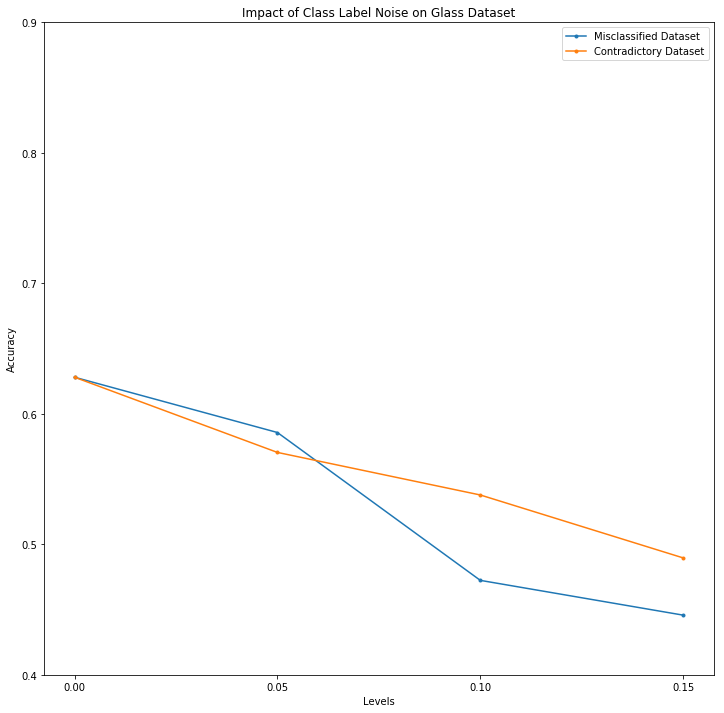

In [292]:
# plot the results from 10 time 10 CV for glass dataset
fig, ax = plt.subplots(figsize=(12,12))
plt.plot(levels, glass_misclassifed_acc, label='Misclassified Dataset', marker='.')
plt.plot(levels, glass_contradictory_acc, label='Contradictory Dataset', marker='.')
plt.xlabel('Levels')
plt.ylabel('Accuracy')
plt.title('Impact of Class Label Noise on Glass Dataset')
plt.legend()
plt.ylim(0.4, 0.9)
ax.set_xticks(levels)
plt.show()

In [169]:
# do 10 times 10 CV on tic tac toe dataset
pruned = False
levels = [0, 0.05, 0.1, 0.15]

tictactoe_misclassifed_acc = []
tictactoe_contradictory_acc = []
for level in levels:
    
    if level == 0:
        accuracy = np.mean(crossvalidation(tictactoe_clf, tictactoe_X, tictactoe_Y, iters=10, k=10, pruned=pruned))
        tictactoe_misclassifed_acc.append(accuracy)
        tictactoe_contradictory_acc.append(accuracy)
        
    else:
        m_new_x, m_new_y = misclassified(tictactoe_X, tictactoe_Y, level)
        c_new_x, c_new_y = contradictory(tictactoe_X, tictactoe_Y, level)
        
        m_accuracy = np.mean(crossvalidation(tictactoe_clf, m_new_x, m_new_y, iters=10, k=10, pruned=pruned))
        c_accuracy = np.mean(crossvalidation(tictactoe_clf, c_new_x, c_new_y, iters=10, k=10, pruned=pruned))
        
        tictactoe_misclassifed_acc.append(m_accuracy)
        tictactoe_contradictory_acc.append(c_accuracy)
        

print(f"Levels: {levels}")
print(f"Misclassified Accuracy: {tictactoe_misclassifed_acc}")
print(f"Contradictory Accuracy: {tictactoe_contradictory_acc}")

Levels: [0, 0.05, 0.1, 0.15]
Misclassified Accuracy: [0.8478947368421054, 0.7566315789473684, 0.7225263157894737, 0.6303157894736844]
Contradictory Accuracy: [0.8478947368421054, 0.7563000000000001, 0.662952380952381, 0.6016363636363635]


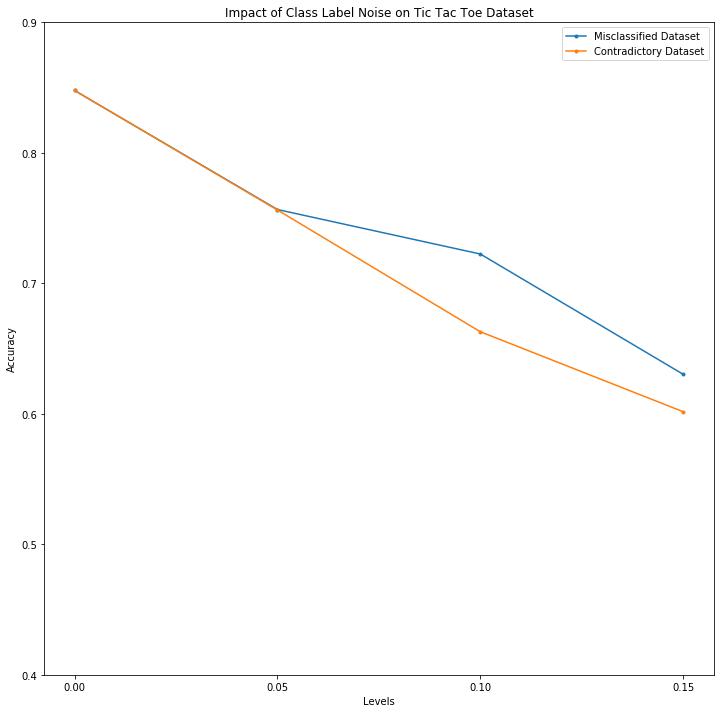

In [291]:
# plot the results from 10 time 10 CV for tic tac toe dataset
fig, ax = plt.subplots(figsize=(12,12))
plt.plot(levels, tictactoe_misclassifed_acc, label='Misclassified Dataset', marker='.')
plt.plot(levels, tictactoe_contradictory_acc, label='Contradictory Dataset', marker='.')
plt.xlabel('Levels')
plt.ylabel('Accuracy')
plt.title('Impact of Class Label Noise on Tic Tac Toe Dataset')
plt.legend()
plt.ylim(0.4, 0.9)
ax.set_xticks(levels)
plt.show()

## Question 3

In [15]:
# load mnist dataset
X_train, Y_train = loadlocal_mnist(
        images_path='datasets/train-images.idx3-ubyte', 
        labels_path='datasets/train-labels.idx1-ubyte')

X_test, Y_test = loadlocal_mnist(
        images_path='datasets/t10k-images.idx3-ubyte', 
        labels_path='datasets/t10k-labels.idx1-ubyte')

In [198]:
# part a

# objective function: interclass distance based on euclidean distance metric
def objFn(means):
    mu_t = [np.mean(means, axis=0)]
    return np.sum(cdist(mu_t, means, 'euclidean'))
    
# bidirectional search algorithm
def bidirectionalSearch(X, Y, iters):
    numfeatures = X.shape[1]
    sfs = []                        # initialize empty SFS list
    sbs = list(range(numfeatures))  # initialize SBS list with all feature indexes
    
    # obtain indexes by class
    nclass = len(np.unique(Y))
    idxByClass = []
    for x in np.unique(Y):
        idxByClass.append(np.argwhere(Y == x).ravel())
    
    for k in range(iters):
        print(f"Iteration #: {k+1}")
        # select best feature
        best_ftIdx = None
        best_score = 0
        
        fwd = [i for i in sbs if i not in sfs]
        for ftIdx in fwd:
            currSet = sfs + [ftIdx]
            currX = X[:, currSet]
            means = [currX[idxByClass[i]].mean(axis=0) for i in range(nclass)]
            score = objFn(means)
            
            if score > best_score:
                best_score = score
                best_ftIdx = ftIdx
        
        # update SFS list
        sfs.append(best_ftIdx)
        
        # remove worst feature
        worst_ftIdx = None
        best_score = 0
        
        bkwd = [i for i in sbs if i not in sfs]
        for ftIdx in bkwd:
            currSet = [i for i in sbs if i != ftIdx]
            currX = X[:, currSet]
            means = [currX[idxByClass[i]].mean(axis=0) for i in range(nclass)]
            score = objFn(means)
            
            if score > best_score:
                best_score = score
                worst_ftIdx = ftIdx
        
        # update SBS list
        sbs.remove(worst_ftIdx)
    
    return sfs
    

In [206]:
%%time
f = 392

print(f"*** Feature Set: {f} ***")
featureSet = bidirectionalSearch(X_train[:10000], Y_train[:10000], f)

*** Feature Set: 392 ***
Iteration #: 1
Iteration #: 2
Iteration #: 3
Iteration #: 4
Iteration #: 5
Iteration #: 6
Iteration #: 7
Iteration #: 8
Iteration #: 9
Iteration #: 10
Iteration #: 11
Iteration #: 12
Iteration #: 13
Iteration #: 14
Iteration #: 15
Iteration #: 16
Iteration #: 17
Iteration #: 18
Iteration #: 19
Iteration #: 20
Iteration #: 21
Iteration #: 22
Iteration #: 23
Iteration #: 24
Iteration #: 25
Iteration #: 26
Iteration #: 27
Iteration #: 28
Iteration #: 29
Iteration #: 30
Iteration #: 31
Iteration #: 32
Iteration #: 33
Iteration #: 34
Iteration #: 35
Iteration #: 36
Iteration #: 37
Iteration #: 38
Iteration #: 39
Iteration #: 40
Iteration #: 41
Iteration #: 42
Iteration #: 43
Iteration #: 44
Iteration #: 45
Iteration #: 46
Iteration #: 47
Iteration #: 48
Iteration #: 49
Iteration #: 50
Iteration #: 51
Iteration #: 52
Iteration #: 53
Iteration #: 54
Iteration #: 55
Iteration #: 56
Iteration #: 57
Iteration #: 58
Iteration #: 59
Iteration #: 60
Iteration #: 61
Iteratio

In [211]:
# use knn and report accuracy
fs = [10, 50, 150, 392]
k = 3

res = []
for f in fs:
    selectedFt = featureSet[:f]
    knn = KNeighborsClassifier(k, n_jobs=4)
    knn.fit(X_train[:10000, selectedFt], Y_train[:10000])
    y_pred = knn.predict(X_test[:, selectedFt])
    score = accuracy_score(Y_test, y_pred)
    res.append(score)
    
print(f"Features Sets: {fs}")
print(f"Accuracies:    {res}")

Features Sets: [10, 50, 150, 392]
Accuracies:    [0.5801, 0.8077, 0.9315, 0.9477]


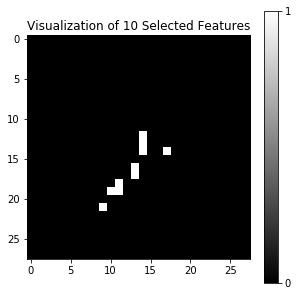

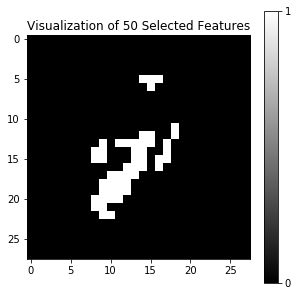

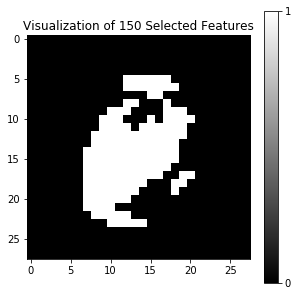

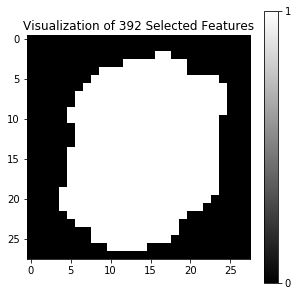

In [248]:
# part b

# plot visualization for each set of features
for f in fs:
    selectedFt = featureSet[:f]
    pixels = np.zeros(28*28, dtype=int)
    pixels[selectedFt]=1
    plane = pixels.reshape(28, 28)
    
    fig, ax = plt.subplots(figsize=(5, 5))
    cax = plt.imshow(plane, cmap='gray', vmin=0, vmax=1)
    plt.colorbar(cax, ticks=[0, 1])    
    plt.title(f"Visualization of {f} Selected Features")
    plt.show()


In [139]:
# part c

# compute within class scatter matrix
def calcSw(mus, X, idxByClass):
    
    # find Sk: (x-mu)*(x-mu)^T for k classes
    Sk = []
    for idx, mu in zip(idxByClass, mus):
        zero_mean_x = X[idx] - mu
        cov = np.matmul(zero_mean_x.T, zero_mean_x)
        Sk.append(cov)
        
    return np.sum(Sk, axis=0)
        
# compute between class scatter mtarix
def calcSb(mus, idxByClass):
    mu_total = np.mean(mus, axis=0)
    
    # find Sb: N_k*(mu_k-mu)*(mu_k-mu)^T
    Sb = []
    for idx, mu in zip(idxByClass, mus):
        N_k = len(idx)
        mu_k_diffed = mu - mu_total
        Sb_k = np.outer(mu_k_diffed, mu_k_diffed) * N_k
        Sb.append(Sb_k)
    
    return np.sum(Sb, axis=0)    

# compute W* by finding eigenvectors
def calcW(Sw, Sb, numclass):
    Sw_inv = np.linalg.pinv(Sw)
    Sw_inv_Sb = np.matmul(Sb, Sw_inv)
    
    # find eigenvalues and eigenvecs
    eig_vals, eig_vecs = np.linalg.eig(Sw_inv_Sb)
    
    # compute W
    order = np.argsort(eig_vals)[::-1]
    W = eig_vecs[:, order[:numclass]].T
    
    return np.real(W)

# compute LDA transformation
def lda(X, Y=None, W=None):
    
    # compute transformation matrix W if not provided
    if W is None:
        # obtain indexes by class
        nclass = len(np.unique(Y))
        idxByClass = []
        for x in np.unique(Y):
            idxByClass.append(np.argwhere(Y == x).ravel())
        
        # find class means
        mus = [X[idxByClass[i]].mean(axis=0) for i in range(nclass)]
        
        # use Sw and Sb to find optimal W by solving eigenvalue problem
        Sw = calcSw(mus, X, idxByClass)
        Sb = calcSb(mus, idxByClass)
        W = calcW(Sw, Sb, nclass)
    
    # compute new_X using transformation matrix W
    new_X = X @ W.T
    
    return new_X, W
    

In [141]:
# use knn with LDA and report accuracy
k = 3

# apply LDA
new_X_train, W = lda(X_train[:10000], Y_train[:10000])
new_X_test, _ = lda(X_test, W=W)

# run knn
knn = KNeighborsClassifier(k, n_jobs=4)
knn.fit(new_X_train, Y_train[:10000])
y_pred = knn.predict(new_X_test)
score = accuracy_score(Y_test, y_pred)

print("MNIST Dataset")
print("Using kNN with LDA")
print("-" * 20)
print(f"Accuracy: {np.mean(score):.4f}")

MNIST Dataset
Using kNN with LDA
--------------------
Accuracy: 0.8964
